<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1: Adil 

# Student 2: Anvitha

# Student 3: Srinidhi Ilango

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [6]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [7]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

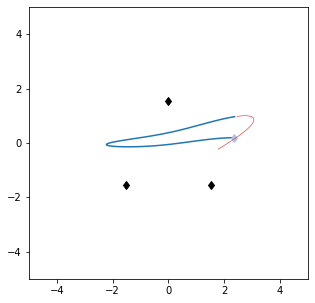

Charges are [-0.09808531 -0.5563076  -0.58221579]


In [8]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

In [5]:
# saving and loading checkpoint mechanisms 
# modules adapted from https://github.com/ttchengab/One_Shot_Pytorch/blob/master/network.ipynb

def save_checkpoint(save_path, model, optimizer, val_loss):
  """
  Utility function for saving the model 

  Input
    --save_path: path to save the model
    --model: model to be saved
    --optimizer: optimizer to be saved
    --val_loss: lowest validation loss so far

  Output
    Saved model as pt file
  """
  if save_path==None:
      return
  save_path = save_path 
  state_dict = {'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss}

  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')


def load_checkpoint(model, optimizer):
  """
  Utility function to load a saved model
  Input
    --model: model object to load the weights into
    --optimizer: optimizer object
    
  Output:
    Validation loss
  """
  save_path = f'SiameseNetwork.pt'
  state_dict = torch.load(save_path)
  model.load_state_dict(state_dict['model_state_dict'])
  optimizer.load_state_dict(state_dict['optimizer_state_dict'])
  val_loss = state_dict['val_loss']
  print(f'Model loaded from <== {save_path}')
  
  return val_loss

# Task 3.1

## Data Handling and Preprocessing

Here, we deliberated over one of the following two options as the simulations have different lengths:
1. zero padding to match the simulation lenghts
2. without zero padding, pass one simuation at a time into the network and aggregate the outputs for backprop [ref1](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/12#:~:text=2%20MONTHS%20LATER-,GalAvineri,-cdjhz), [ref2](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch)

We now try the second option <br>
-- the model should be invariant to rotation, not sure about the implementation
[REF](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/13)

In [6]:
#todo 
#1: can add data normalization later
#2: data augmentation - slice through longer time points as the outputs must remain same

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

def collate_batch(batch):
    '''
    Args:
        batch: batch sizes list of tuples (features, target)
    
    Returns:
        packed data and corresponding targets
    
    '''
    data = [torch.from_numpy(item[0]).float() for item in batch]
    lengths = [d.size(0) for d in data]

    padded_data = pad_sequence(data, batch_first=True, padding_value=0)
    packed_data = pack_padded_sequence(padded_data, lengths, batch_first=True, enforce_sorted=False)
    
    targets = np.array([item[1] for item in batch])

    return packed_data, torch.tensor(targets).float() #.to(device)
    

d:\installations\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# defining a DataLoaders for training, validation and testing
 
batch_len = 8

train_loader = DataLoader(tuple(zip(simulation_train, charges_train)), batch_size = batch_len, 
                        collate_fn = collate_batch,pin_memory=True)

val_loader = DataLoader(tuple(zip(simulation_valid, charges_valid)), batch_size = batch_len, 
                        collate_fn = collate_batch,pin_memory=True)

test_loader = DataLoader(tuple(zip(simulation_test, charges_train)),batch_size=1,
                        collate_fn = collate_batch,pin_memory=True)

### workshpace

In [ ]:
# def collate_batch(batch):
#     # batch cointains a list of tuples of structure (sequence, target)
#     data = [torch.from_numpy(item[0]) for item in batch]
#     # print(len(data))
#     data = pack_sequence(data, enforce_sorted=False)
#     # print(len(data))
#     targets = np.array([item[1] for item in batch])
#     return data.to(device), torch.tensor(targets).to(device)


In [8]:
for features,targets in test_loader:
    print(len(features))
    break

4


## Model Implementation

[ref1](https://stackoverflow.com/questions/44643137/how-do-you-use-pytorch-packedsequence-in-code)
[ref2](https://www.crosstab.io/articles/time-series-pytorch-lstm)

In [14]:
#todo: clean up code, understand it better
# can add normalizatoin, dropouts, regularization

from torch import nn

class RegressionLSTM(nn.Module):
    """
    LSTM model to find the charge of three particles
    """
    def __init__(self, inp_size=2, hidden_size=110, n_layers=1, batch_size=8):
        super(RegressionLSTM, self).__init__()
        
        self.inp_size = inp_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.rnn = nn.LSTM(
            input_size = self.inp_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True
        )

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=3)

    
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, self.batch_size ,self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.n_layers, self.batch_size, self.hidden_size).requires_grad_()
        
        _,(hn,_) = self.rnn(x,(h0,c0))
        output = self.linear(hn[0])

        return output

### rough work

In [23]:
from torch.autograd import Variable
num_layers = 1
hidden_size = 110
input_size = 2
batch_size = 3
rnn = nn.LSTM(input_size =2, hidden_size = 110, num_layers = 1, batch_first = True)
# lSTM output is (batch_size,seq_len, num_directions * hidden_size)
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
linear = nn.Linear(in_features= hidden_size, out_features=3)

for batch, target in train_loader:
    
    # seq_len, batch_size
    h0 = torch.zeros(num_layers, batch_size ,hidden_size).requires_grad_()
    c0 = torch.zeros(num_layers, batch_size, hidden_size).requires_grad_()
    # hidden = (h0,c0)
    # out,_ = rnn(batch,h0)
    o, (h0, c0) = lstm(batch,(h0,c0))
    out = linear(h0[0])#.flatten()
    print(out)
    print(target)

    break

tensor([[-0.0185,  0.0870,  0.0483],
        [-0.0731,  0.0732,  0.0449],
        [-0.0878,  0.0741,  0.0564]], grad_fn=<AddmmBackward0>)
tensor([[-0.9951, -0.4482, -0.2730],
        [-0.9845, -0.1668, -0.3479],
        [-0.0918, -0.3541, -0.6817]], dtype=torch.float64)


In [26]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# https://stackoverflow.com/questions/44643137/how-do-you-use-pytorch-packedsequence-in-code


# data = [torch.tensor([1]),
#         torch.tensor([2, 3, 4, 5]), 
#         torch.tensor([6, 7]),
#         torch.tensor([8, 9, 10])]

data = [torch.tensor(data).float() for data in simulation_train[:2]]
lengths = [d.size(0) for d in data]

padded_data = pad_sequence(data, batch_first=True, padding_value=0) 
padded_data.required_grad = True
# embedding = nn.Embedding(20, 4, padding_idx=0)
# embeded_data = embedding(padded_data)

packed_data = pack_padded_sequence(padded_data, lengths, batch_first=True, enforce_sorted=False)
lstm = nn.LSTM(input_size=2, hidden_size=3, batch_first=True)
o, (h, c) = lstm(packed_data)

# (h, c) is the needed final hidden and cell state, with index already restored correctly by LSTM.
# but o is a PackedSequence object, to restore to the original index:

unpacked_o, unpacked_lengths = pad_packed_sequence(o, batch_first=True)
# now unpacked_o, (h, c) is just like the normal output you expected from a lstm layer.

print(unpacked_o, unpacked_lengths)

## Model Training

In [35]:
# trainng and validation for every epoch

def train(model, train_loader, val_loader, num_epochs, loss_fn, save_name):
    
    best_val_loss = float("Inf") 
    train_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for X, y in tqdm(train_loader):
            output = model(X)
            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        avg_train_loss = running_loss/ len(train_loader)
        train_losses.append(avg_train_loss)


        val_running_loss = 0.0
        val_losses = []
        with torch.no_grad():
            model.eval()
            for X,y in val_loader:
                output = model(X)
                loss = loss_fn(output, y)
            val_running_loss += loss.item()

        avg_val_loss = val_running_loss/ len(val_loader)
        val_losses.append(avg_val_loss)

        print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}'
                .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))

        if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print('Finished Training!!')
    return train_losses, val_losses


In [36]:
#todo
from tqdm import tqdm 

lr = 1e-5
hidden_units = 16

model = RegressionLSTM(batch_size=batch_len)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
num_epochs = 2

save_path = 'test_run1.pt'
train_losses, val_losses = train(model, train_loader, val_loader, 
                                num_epochs, loss_fn, save_path)

100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch [1/2], train_loss: 0.0035, val_loss: 0.0349
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


Epoch [2/2], train_loss: 0.0034, val_loss: 0.0339
Model saved to ==> test_run1.pt
Finished Training!!


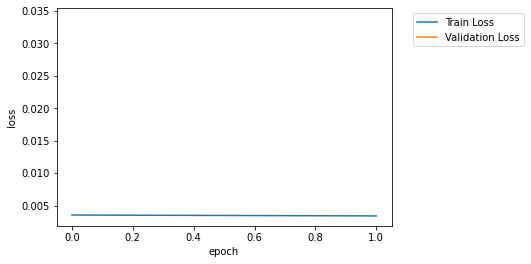

In [37]:
#plotting training vs validation loss
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### workspace

In [22]:
from tqdm import tqdm

from tqdm import tqdm 

lr = 1e-5
hidden_units = 16

model = RegressionLSTM(batch_size=batch_len)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

total_loss = 0
# num_batches = 
model.train()

for X,y in tqdm(train_loader):
    output = model(X)
    loss = loss_fn(output,y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

with torch.no_grad():
    model.eval()
    for X,y in val_loader:
        output = model(X)
        loss = loss_fn(output, y)

100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


In [20]:
val_running_loss = 0.0

with torch.no_grad():
    model.eval()
    for X,y in val_loader:
        output = model(X)
        loss = loss_fn(output, y)
    val_running_loss += loss
    

## Evaluation

In [7]:
#todo : evaluate the model performance on the test set
# check the training example it performs the worst on 
# try to obtain possible reasons for such performance

# Task 3.2

## Data Handling and Preprocessing

In [8]:
#todo

## Model Implementation

In [9]:
#todo

## Model Training

In [10]:
#todo

## Evaluation

In [11]:
#todo